In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-01-21 17:16:51'

# Step-size sweeps

For dense single layer LSTMs on row-wise sequential MNIST task

In [4]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': True,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [6]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [10]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 60)

db1 = DbAccessor('hshah1_001_tbptt_lstm_dense', timestep_col_name="timestep", local=False, gc=True)
comment1='tbptt_long'
db2 = DbAccessor('hshah1_002_bptt_lstm_dense', timestep_col_name="timestep", local=False, gc=True)
comment2 = 'step_size_sweep'
db3 = DbAccessor('hshah1_003_bptt_lstm_echostate', timestep_col_name="timestep", local=False, gc=True)
comment3 = 'step_size_sweep'
db4 = DbAccessor('hshah1_004_tbptt_lstm_dense_sweep', timestep_col_name="timestep", local=False, gc=True)
comment4='tbptt_step_size_sweep'

for db in [db1,db2,db3,db4]:
    try:
        pd.read_sql(f'ALTER TABLE runs DROP COLUMN db, DROP COLUMN db_prefix;', db.conn)
    except:
        continue

In [11]:
#pd.read_sql(f'select * from runs', db1.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db1.conn)

,run_id,seed,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,211802076,0,tbptt_long,2100000,32,1,LSTM,0,0,10,0.1,211802076,tbptt_long,finished,2100000,35,0.010870,0.930127,0.011654,0.9307,7:59:35.557759
1,211802081,0,tbptt_long,2100000,32,1,LSTM,0,0,5,0.1,211802081,tbptt_long,finished,2100000,35,0.023471,0.847710,0.024661,0.8447,6:26:44.715437


In [12]:
#pd.read_sql(f'select * from runs', db2.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db2.conn)

,run_id,seed,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,211846543,2,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.100,211846543,step_size_sweep,finished,2100000,35,0.003956,0.977759,0.003991,0.9751,7:14:04.894073
1,211846545,1,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.001,211846545,step_size_sweep,finished,2100000,35,0.021725,0.884956,0.021462,0.8907,7:12:23.787337
2,211846550,0,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.050,211846550,step_size_sweep,finished,2100000,35,0.002301,0.988529,0.003765,0.9770,7:15:30.317995
3,211846567,0,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.100,211846567,step_size_sweep,finished,2100000,35,0.004493,0.973788,0.004082,0.9768,7:16:48.238279
4,211846568,2,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.005,211846568,step_size_sweep,finished,2100000,35,0.005933,0.964132,0.005235,0.9679,7:16:30.454019
5,211846570,2,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.050,211846570,step_size_sweep,finished,2100000,35,0.003549,0.978906,0.003264,0.9809,7:15:29.943977
6,211846576,1,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.005,211846576,step_size_sweep,finished,2100000,35,0.005302,0.970553,0.005371,0.9680,7:14:14.915609
7,211846598,0,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.005,211846598,step_size_sweep,finished,2100000,35,0.004263,0.975201,0.004501,0.9735,7:15:45.276769
8,211846599,2,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.001,211846599,step_size_sweep,finished,2100000,35,0.015253,0.916044,0.015956,0.9146,7:16:05.911082
9,211847001,1,step_size_sweep,2100000,32,1,LSTM,0,0,100000,3,0.050,211847001,step_size_sweep,finished,2100000,35,0.002778,0.985419,0.003451,0.9796,7:14:23.413530


In [13]:
#pd.read_sql(f'select * from runs', db3.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db3.conn)

,run_id,seed,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,211853552,2,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.050,211853552,step_size_sweep,finished,2100000,35,0.074870,0.483952,0.075319,0.4660,4:37:11.932214
1,211853557,1,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.500,211853557,step_size_sweep,finished,2100000,35,0.081065,0.348370,0.078638,0.3335,4:33:57.375312
2,211853570,0,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.005,211853570,step_size_sweep,finished,2100000,35,0.076521,0.473961,0.076114,0.4783,4:39:08.113312
3,211853577,0,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.500,211853577,step_size_sweep,finished,2100000,35,0.078755,0.393967,0.081118,0.3834,4:34:25.072294
4,211853581,0,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.050,211853581,step_size_sweep,finished,2100000,35,0.073847,0.497876,0.073236,0.5256,4:36:08.166476
5,211854049,2,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.100,211854049,step_size_sweep,finished,2100000,35,0.075091,0.474144,0.075300,0.4536,4:37:53.186254
6,211854062,1,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.100,211854062,step_size_sweep,finished,2100000,35,0.076628,0.423979,0.075839,0.4447,4:34:13.746983
7,211854078,0,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.010,211854078,step_size_sweep,finished,2100000,35,0.075460,0.491750,0.074998,0.4980,4:38:01.960192
8,211854084,0,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.001,211854084,step_size_sweep,finished,2100000,35,0.079777,0.386784,0.079422,0.3998,4:36:37.969487
9,211854093,2,step_size_sweep,2100000,32,1,LSTM,0,1,100000,3,0.500,211854093,step_size_sweep,finished,2100000,35,0.080127,0.375160,0.077086,0.4457,4:37:35.426171


In [14]:
#pd.read_sql(f'select * from runs', db4.conn)
pd.read_sql(f'select * from runs join run_states where runs.run_id = run_states.run_id', db4.conn)

,run_id,seed,comment,n_timesteps,hidden_size,n_layers,model,sparse,echo_state,truncation_length,n_threads,step_size,run_id,comment,state,timestep,epoch,training_error,training_acc,test_error,test_acc,run_time
0,211938355,0,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,211938355,tbptt_step_size_sweep,finished,2100000,35,0.048965,0.648309,0.048355,0.6514,5:33:45.190295
1,211938365,1,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,211938365,tbptt_step_size_sweep,finished,2100000,35,0.045798,0.677775,0.045864,0.6762,5:31:47.029511
2,211938376,2,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.100,211938376,tbptt_step_size_sweep,finished,2100000,35,0.046601,0.665096,0.048476,0.6594,5:31:20.535351
3,211938388,0,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,211938388,tbptt_step_size_sweep,finished,2100000,35,0.057991,0.581607,0.056799,0.6055,5:33:41.299965
4,211938399,1,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,211938399,tbptt_step_size_sweep,finished,2100000,35,0.057111,0.584663,0.054312,0.5969,5:35:19.132697
5,211938411,2,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.500,211938411,tbptt_step_size_sweep,finished,2100000,35,0.057285,0.583942,0.056790,0.5884,5:33:09.951894
6,211938422,0,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.010,211938422,tbptt_step_size_sweep,finished,2100000,35,0.048045,0.662341,0.047015,0.6660,5:31:52.972827
7,211938433,1,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.010,211938433,tbptt_step_size_sweep,finished,2100000,35,0.050989,0.630842,0.050932,0.6273,5:30:38.536698
8,211938445,2,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.010,211938445,tbptt_step_size_sweep,finished,2100000,35,0.049456,0.649294,0.050060,0.6421,5:33:36.350209
9,211938457,0,tbptt_step_size_sweep,2100000,32,1,LSTM,0,0,1,1,0.050,211938457,tbptt_step_size_sweep,finished,2100000,35,0.045755,0.672183,0.043378,0.6968,5:35:51.086958


In [129]:
def plt_individual(comment, NSTEPS, db, color=None, label=None, condition=[]):
    if label==None:
        label=comment
    suitable_runs = pd.read_sql(f'select run_id from test_metrics group by run_id having max(timestep) > {NSTEPS*1000}', db.conn).values
    runs = []
    for run in suitable_runs:
        if condition == []:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}"', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}"', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}" and {condition[1][0]} = "{condition[1][1]}"  ', db.conn).values
        if len(r) !=0:
            runs.append(r[0])
    labelled=False
    for run in runs:
        if color==None:
            if not labelled:
                plt.plot(db.get_table('test_metrics', run[0], 'acc'), label=f'{label}_runs: {len(runs)}')
                labelled=True
            else:
                plt.plot(db.get_table('test_metrics', run[0], 'acc'))
        else:
            if not labelled:
                plt.plot(db.get_table('test_metrics', run[0], 'acc'), label=f'{label}_runs: {len(runs)}', color=color)
                labelled=True
            else:
                plt.plot(db.get_table('test_metrics', run[0], 'acc'), color=color)

In [151]:
def plt_with_err(comment, NSTEPS, db, color, label=None, condition=[], table='test_metrics'):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    suitable_runs = pd.read_sql(f'select run_id from {table} group by run_id having max(timestep) > {NSTEPS*1000}', db.conn).values
    runs = []
    invalid_count = 0
    for run in suitable_runs:
        if condition == []:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}"', db.conn).values
            invalid_r = pd.read_sql(f'select run_id from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}" ', db.conn).values
            invalid_r = pd.read_sql(f'select run_id from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select run_id from runs where run_id={run[0]} and comment="{comment}" and {condition[0][0]} = "{condition[0][1]}" and {condition[1][0]} = "{condition[1][1]}" ', db.conn).values
            invalid_r = pd.read_sql(f'select run_id from run_states where run_id={run[0]} and comment="{comment}" and test_error > 1e+15', db.conn).values
        if len(r) !=0 and np.all(invalid_r != r):
            runs.append(r[0])
        elif len(r) !=0 and np.all(invalid_r == r):
            
            invalid_count += 1

    if table == 'training_metrics':
        col = 'running_acc'
    else:
        col = 'acc'
        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col)[:NSTEPS].to_numpy().reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col)[:NSTEPS].to_numpy().reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col)[:NSTEPS].index.to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    linestyle=':' if table=="training_metrics" else '-'
    plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle)
    if table != "training_metrics":
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.3, color=color)

In [15]:
#p1 = np.unique(pd.read_sql(f'select step_size from runs', db4.conn).to_numpy().squeeze())
#p2 = np.unique(pd.read_sql(f'select truncation_length from runs', db4.conn).to_numpy().squeeze())
#list(itertools.product(p1,p2))

In [16]:
#plt_name = f'001'
#plt.figure(figsize=(16,9), dpi=200)
#plt.title(plt_name)
#plt.xlabel('timestep')
#plt.ylabel('accuracy')

#NSTEPS = 1
#for params in [5,10]:
#    conditions = [['truncation_length', params]]

#    plt_individual(comment1, NSTEPS, db1, None, str(conditions), conditions)

#plt.legend(prop={'size': 9})
#plt.show()

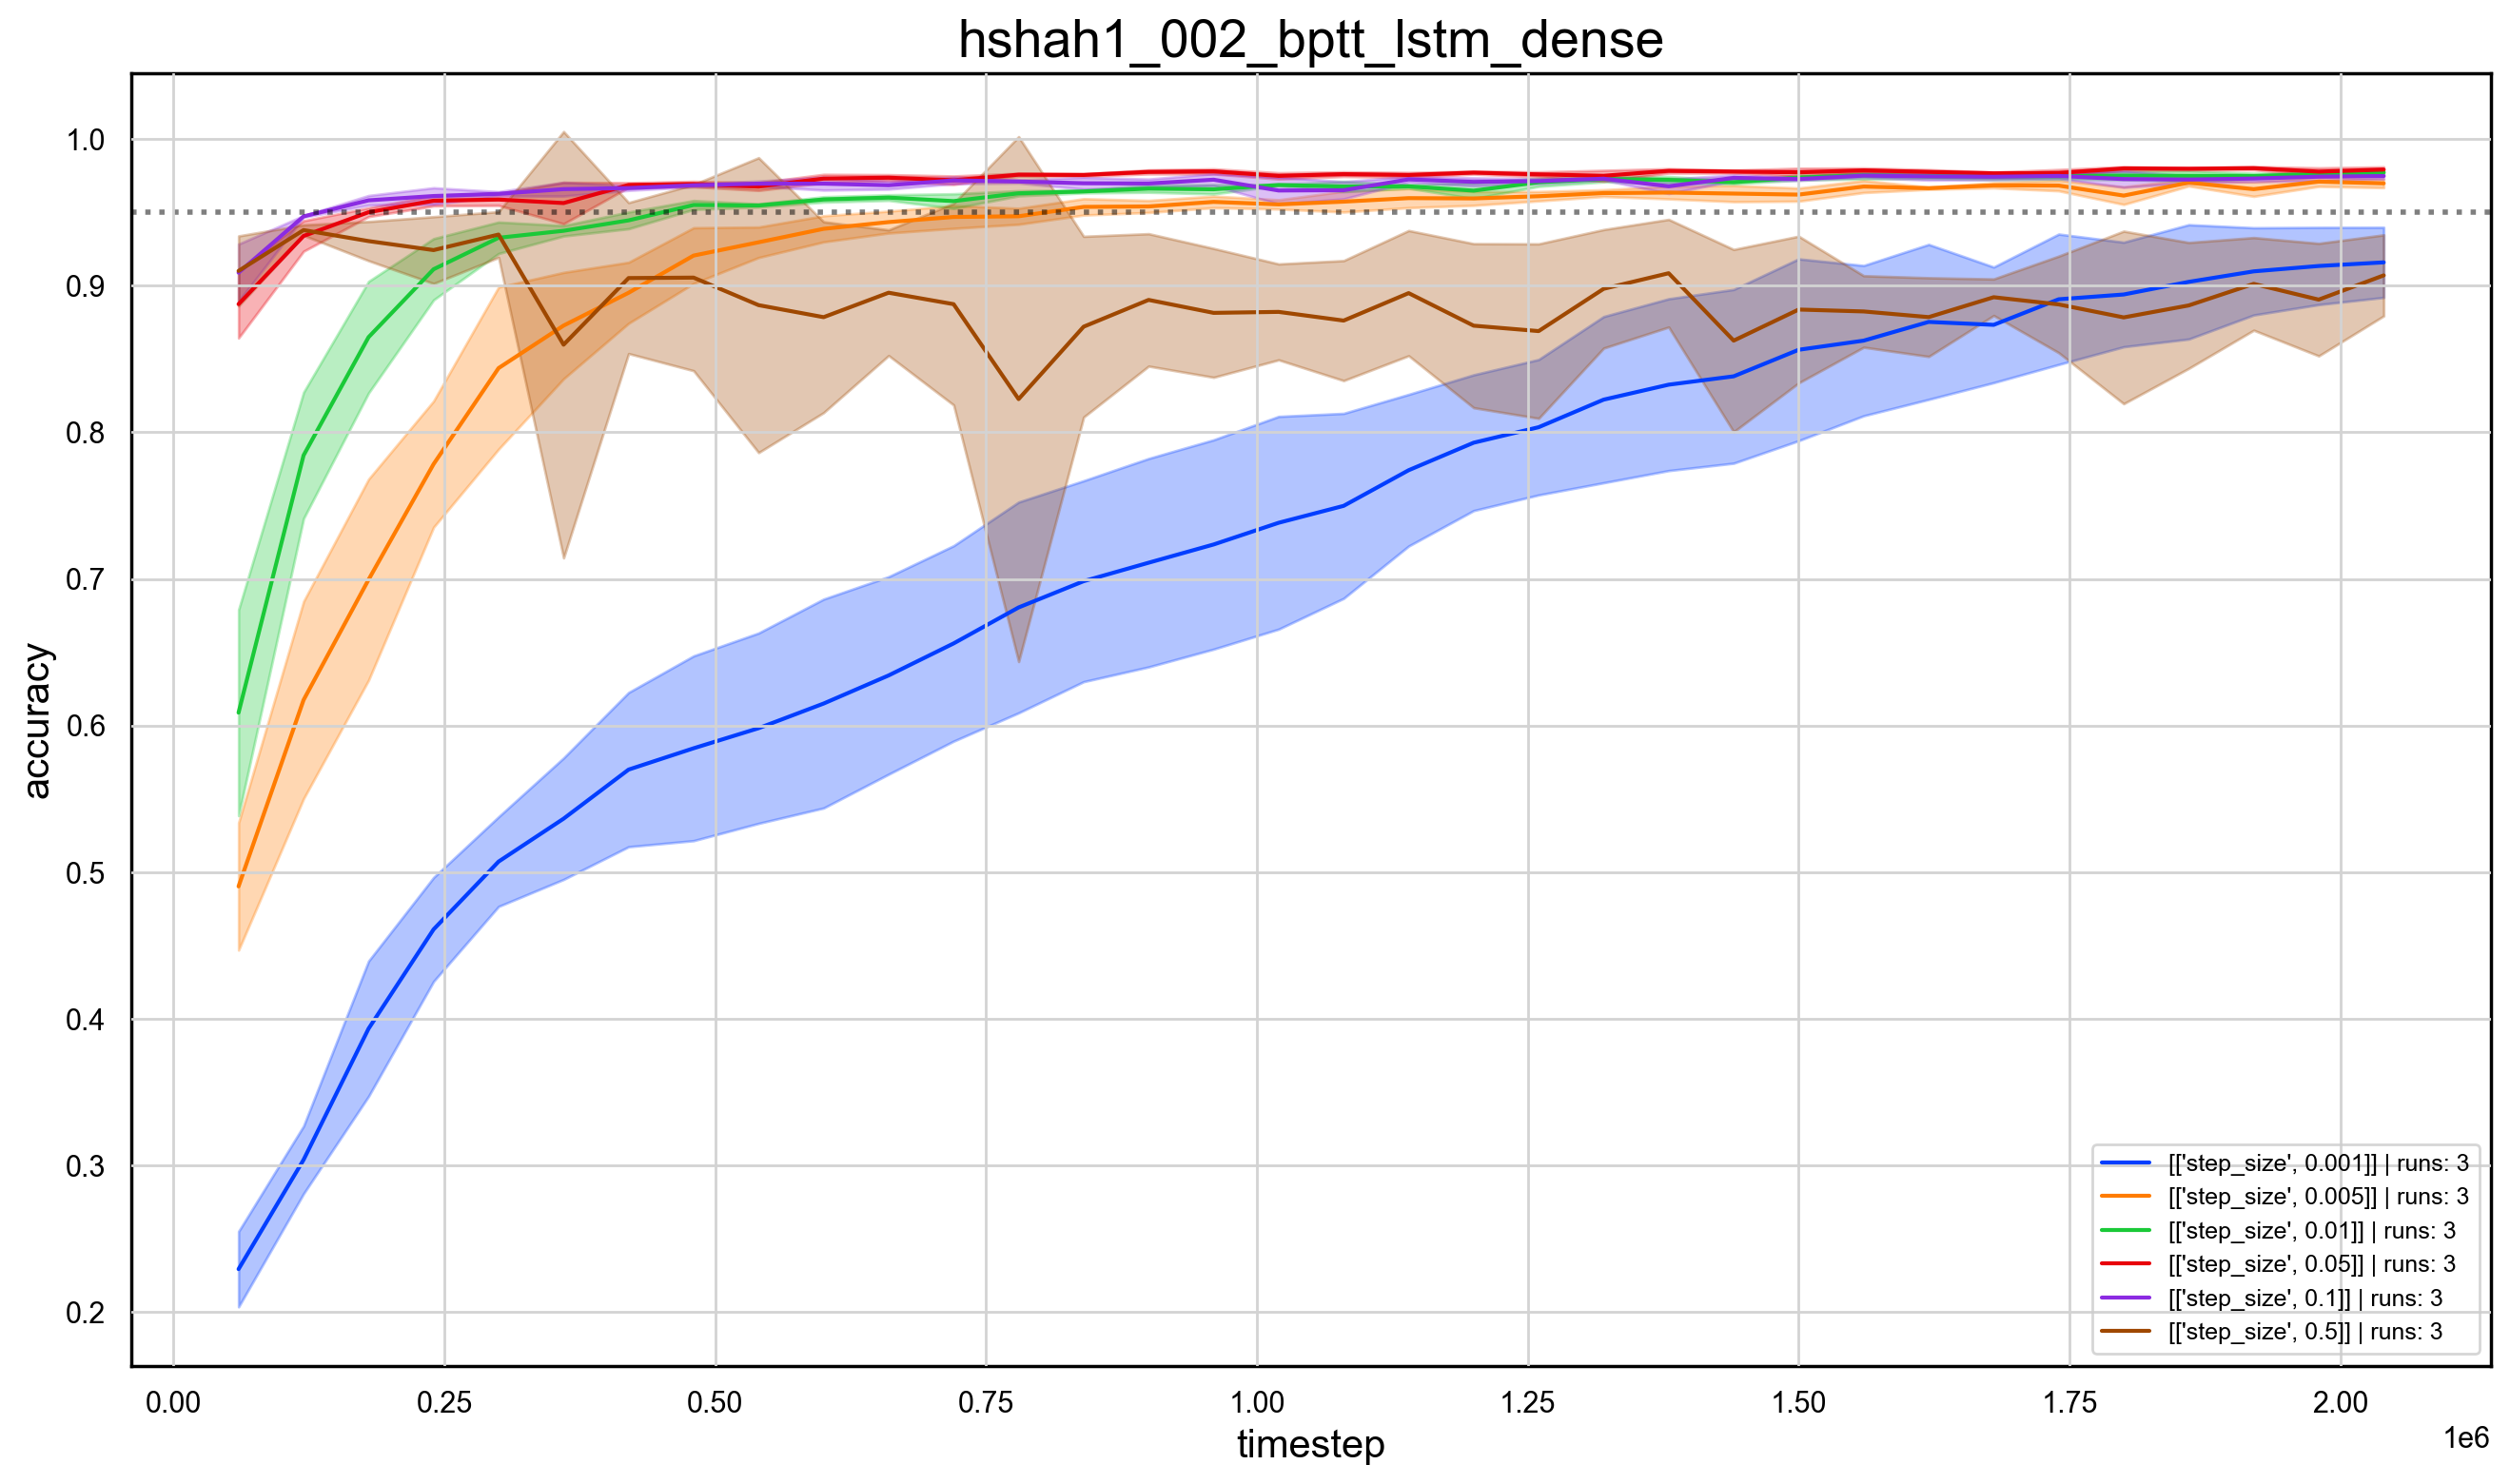

In [133]:
plt_name = f'hshah1_002_bptt_lstm_dense'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 34
for params in np.unique(pd.read_sql(f'select step_size from runs', db2.conn).to_numpy().squeeze()):
    conditions = [['step_size', params]]

    plt_with_err(comment2, NSTEPS, db2, colors[color_idx], str(conditions), conditions)
    color_idx+=1

plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()

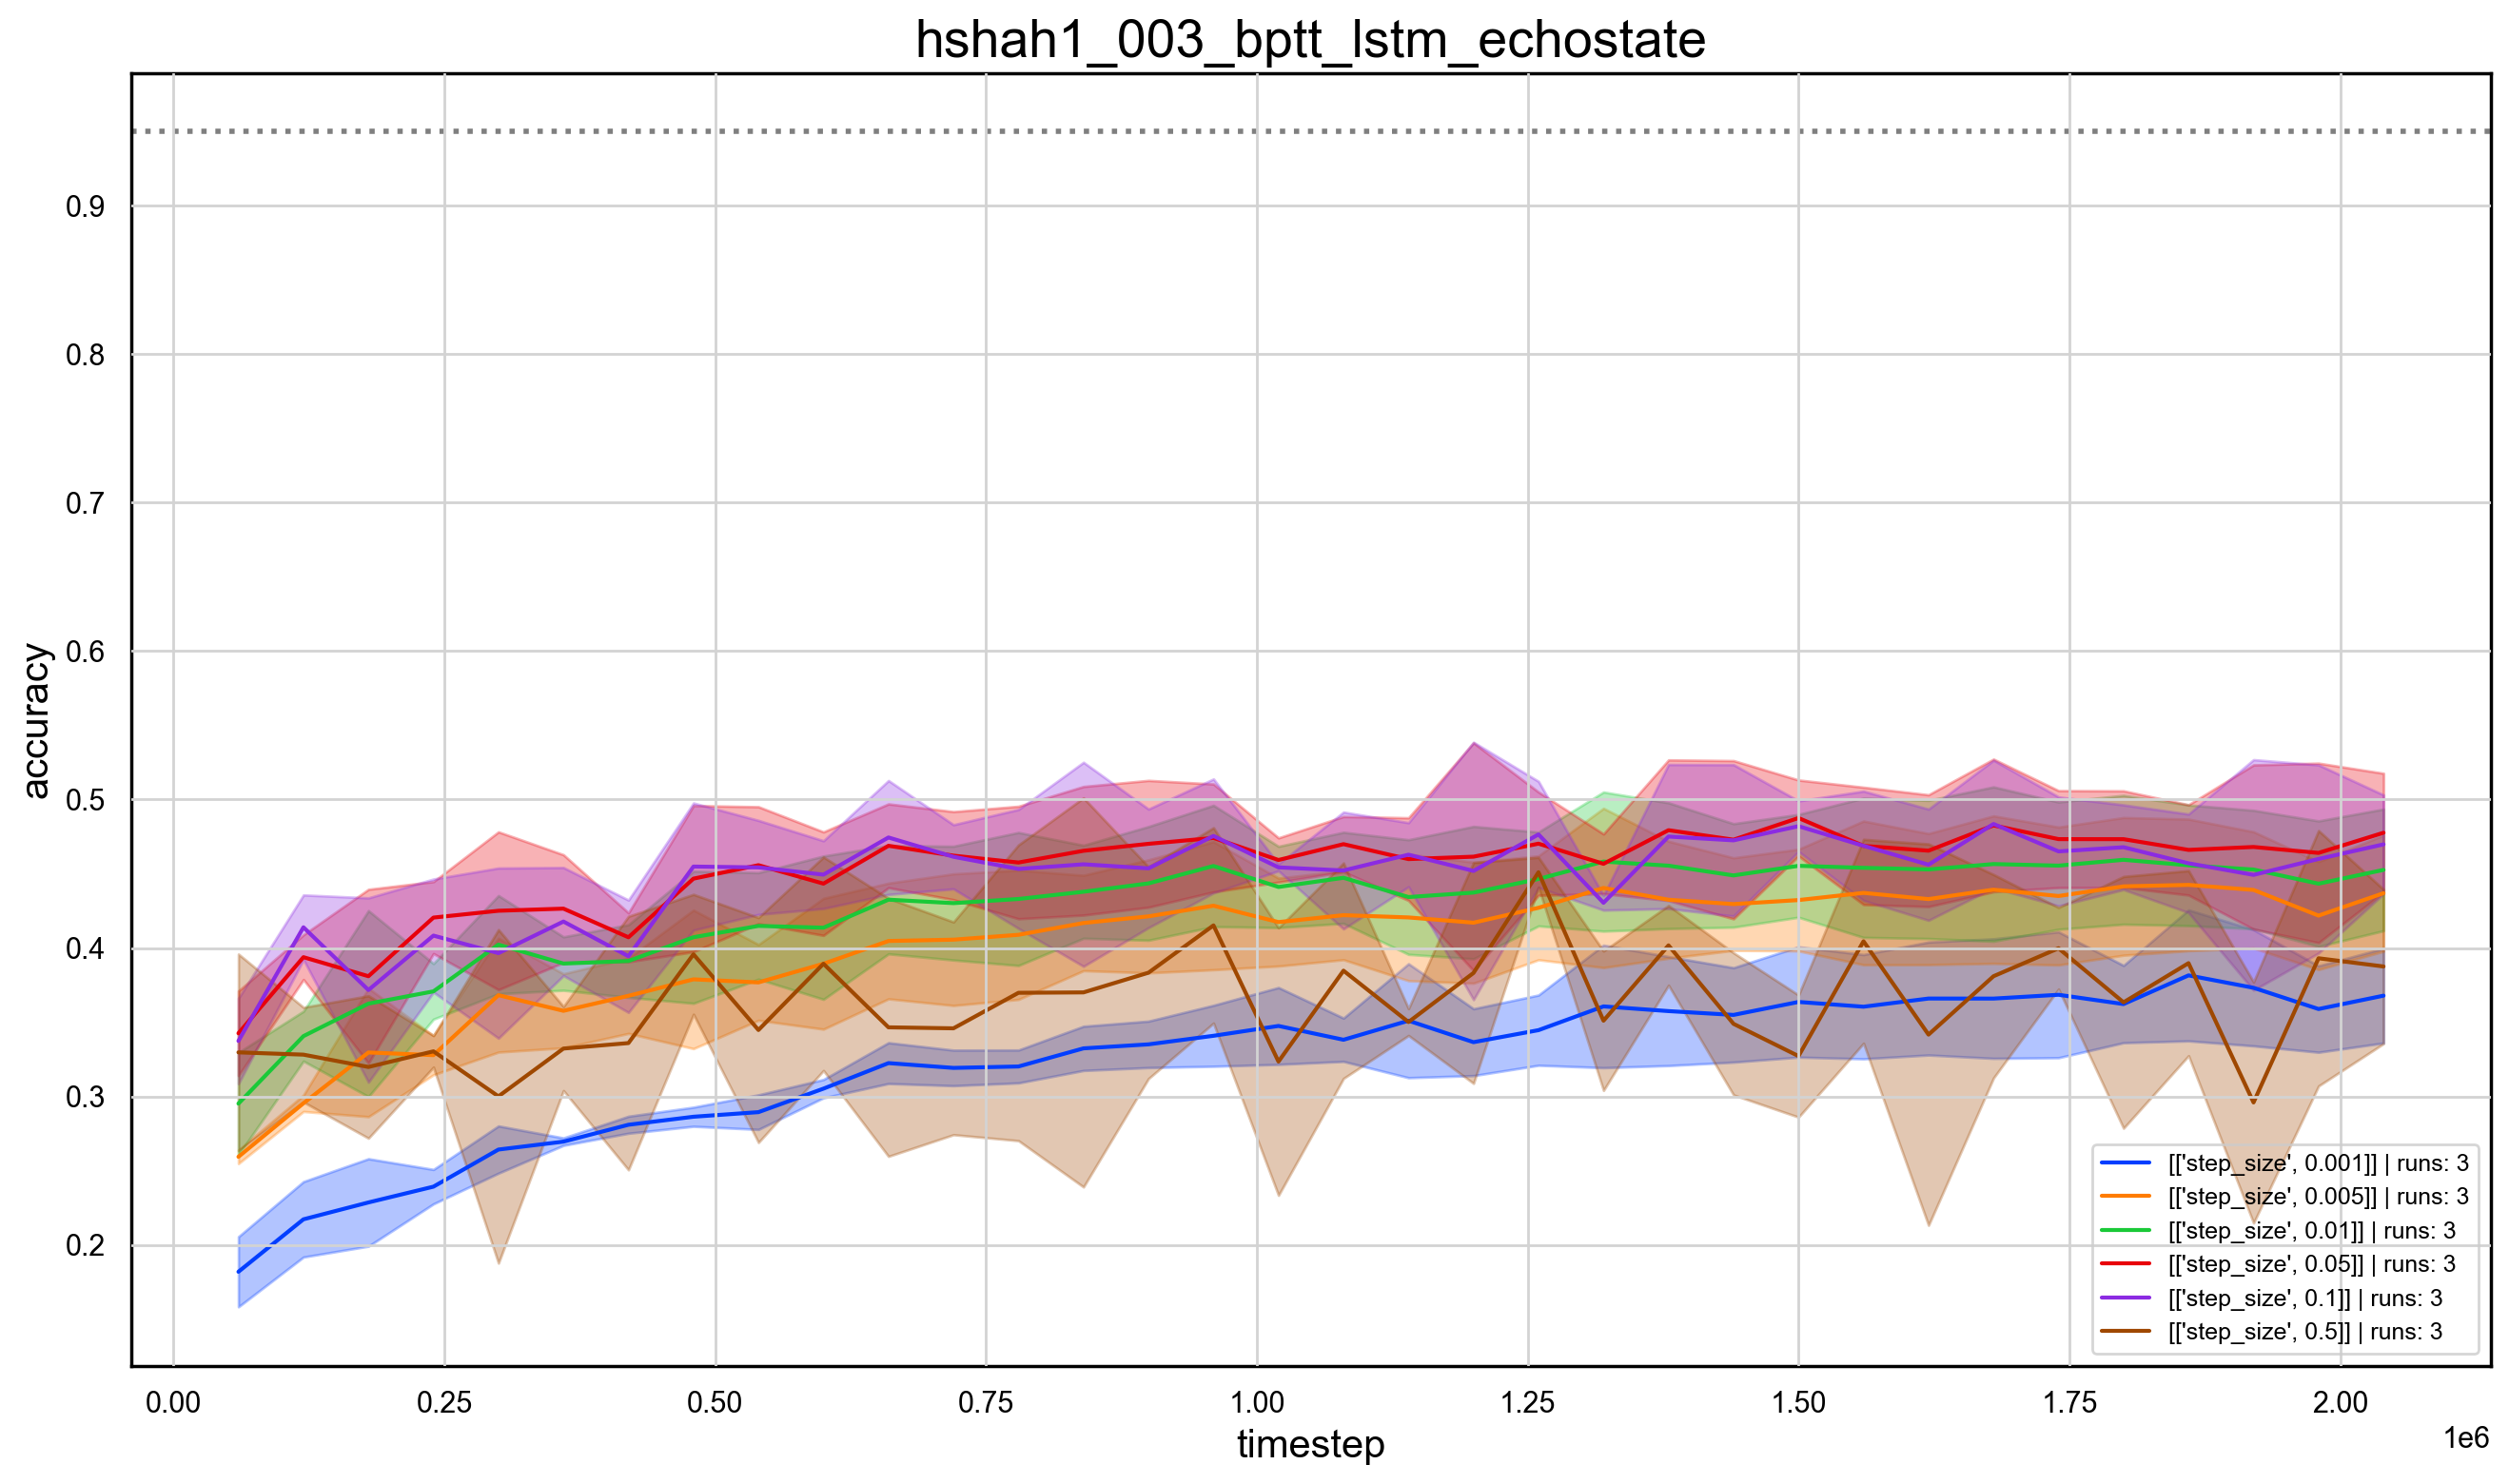

In [134]:
plt_name = f'hshah1_003_bptt_lstm_echostate'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 34
for params in np.unique(pd.read_sql(f'select step_size from runs', db3.conn).to_numpy().squeeze()):
    conditions = [['step_size', params]]

    plt_with_err(comment3, NSTEPS, db3, colors[color_idx], str(conditions), conditions)
    color_idx+=1

plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()

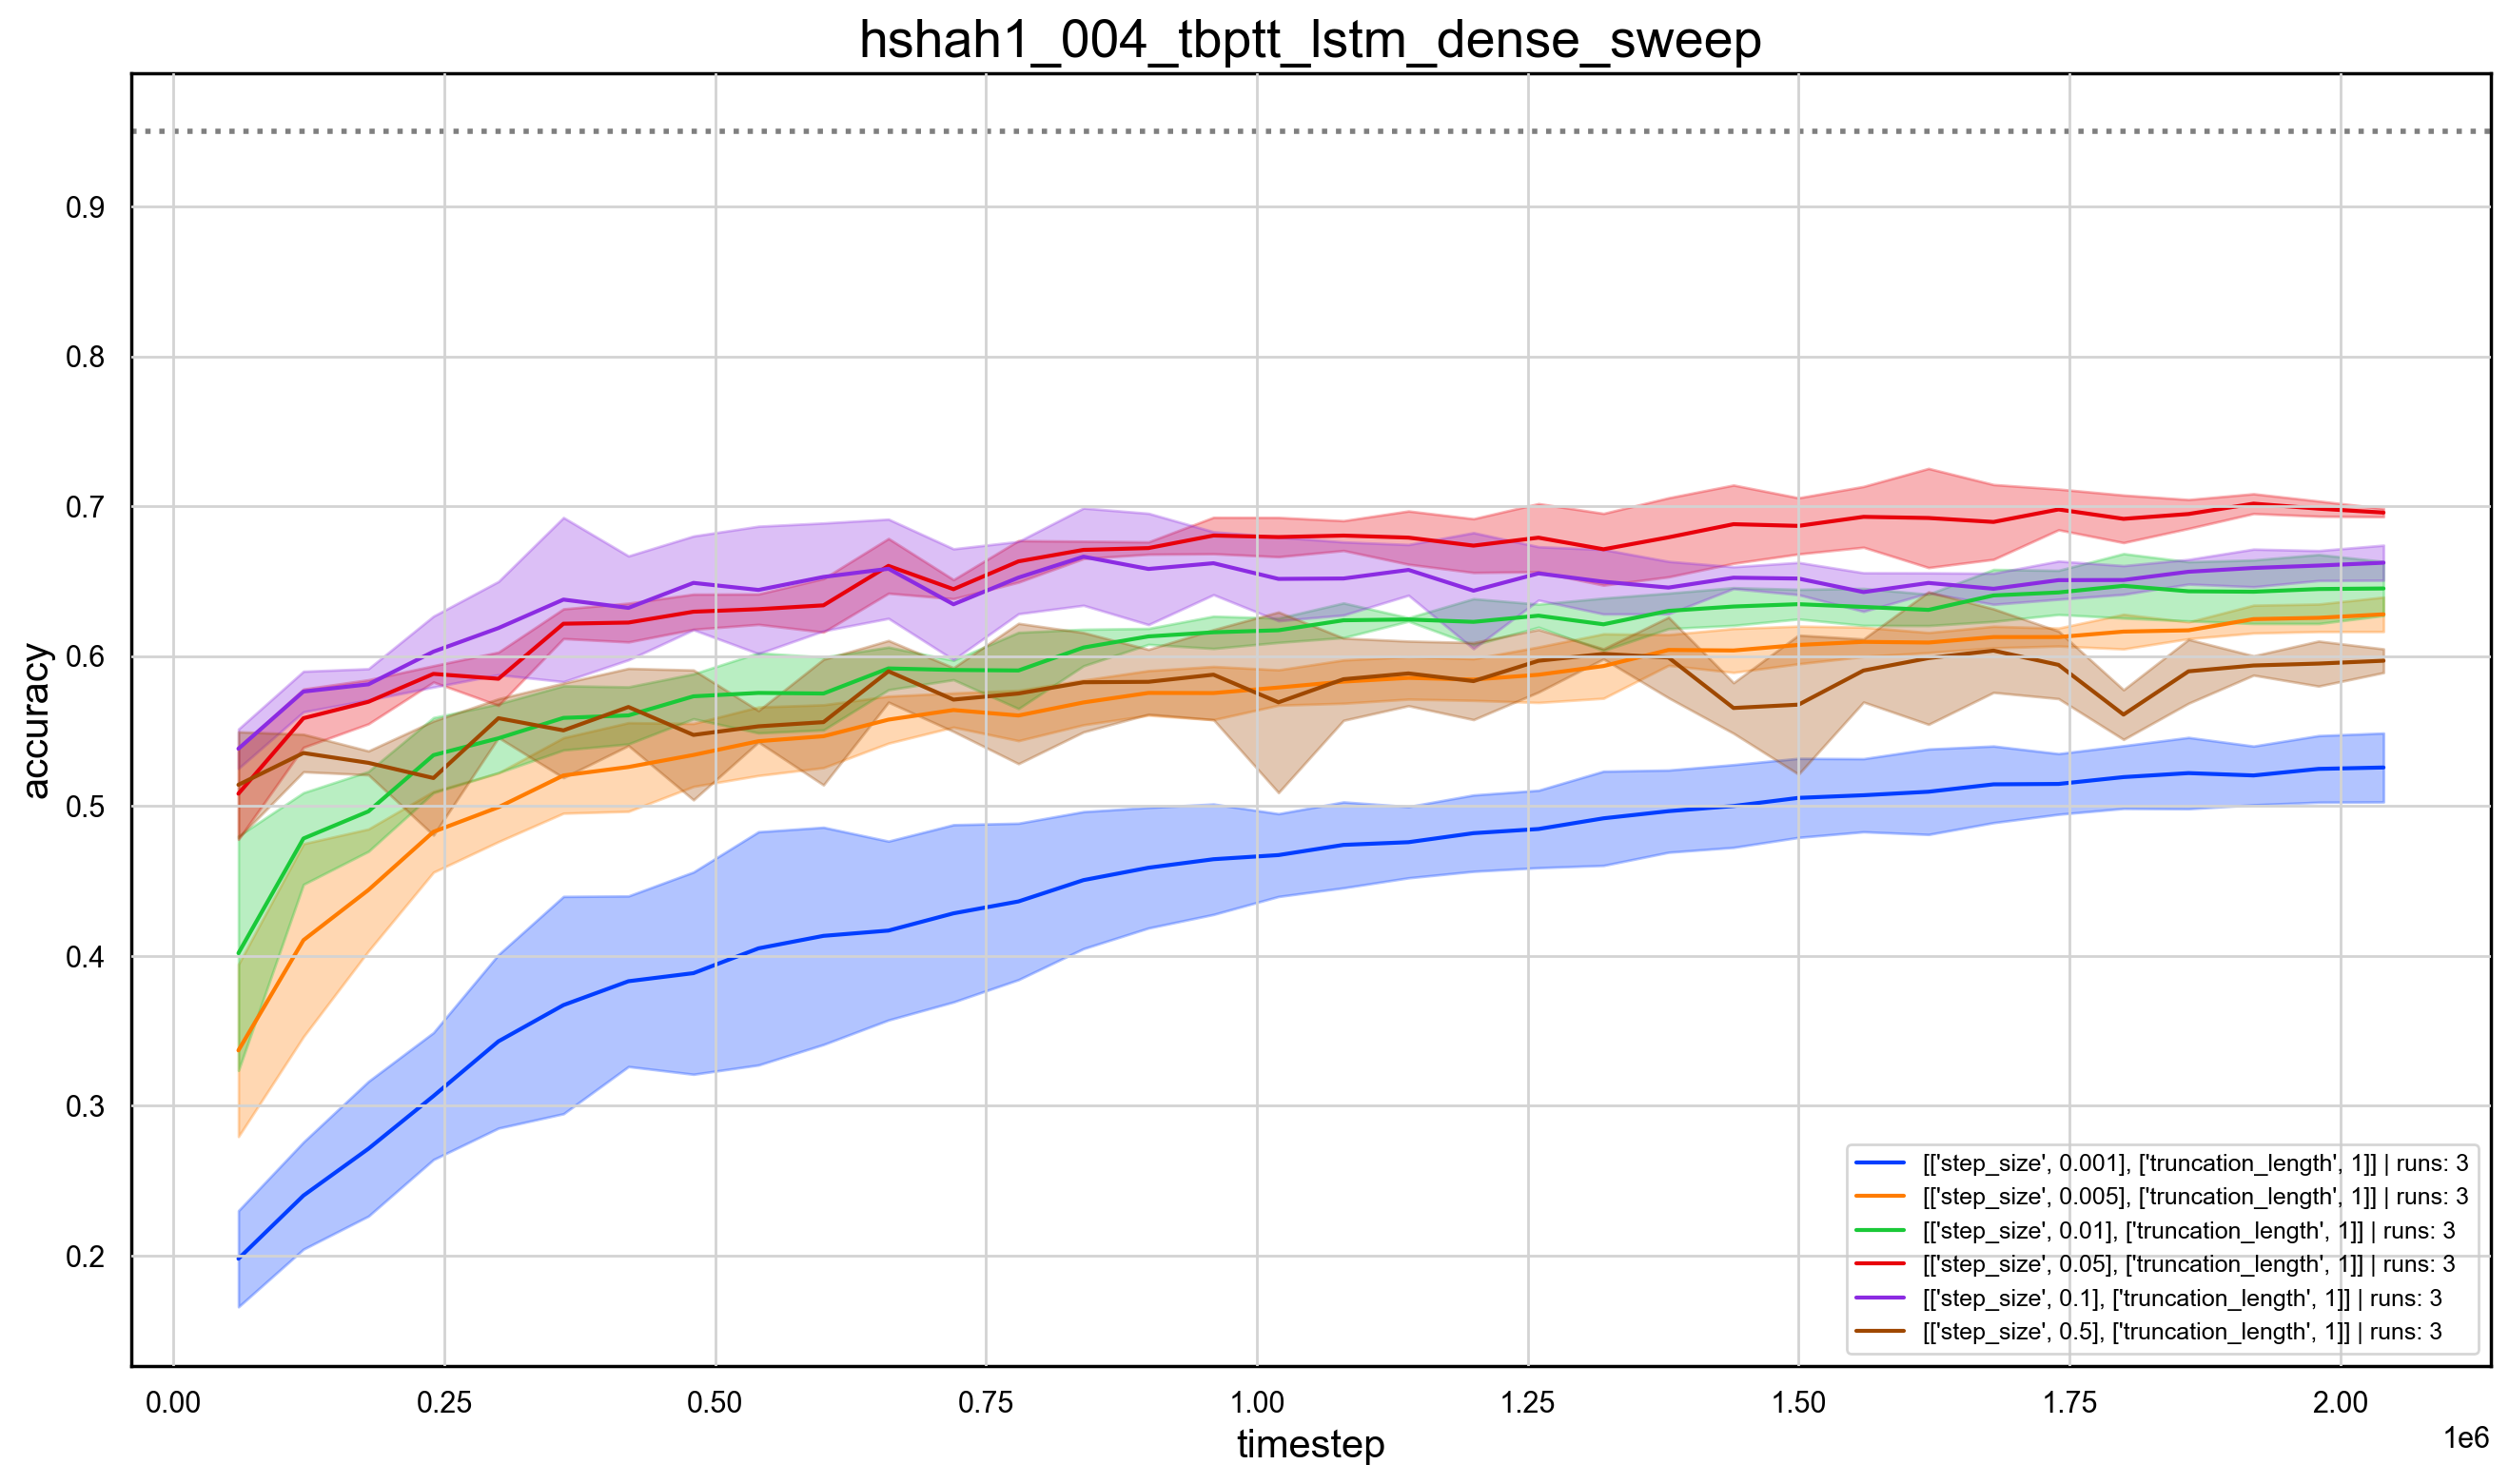

In [135]:
plt_name = f'hshah1_004_tbptt_lstm_dense_sweep'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 34
for params in np.unique(pd.read_sql(f'select step_size from runs', db3.conn).to_numpy().squeeze()):
    conditions = [['step_size', params],
                 ['truncation_length', 1]]

    plt_with_err(comment4, NSTEPS, db4, colors[color_idx], str(conditions), conditions)
    color_idx+=1

plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()

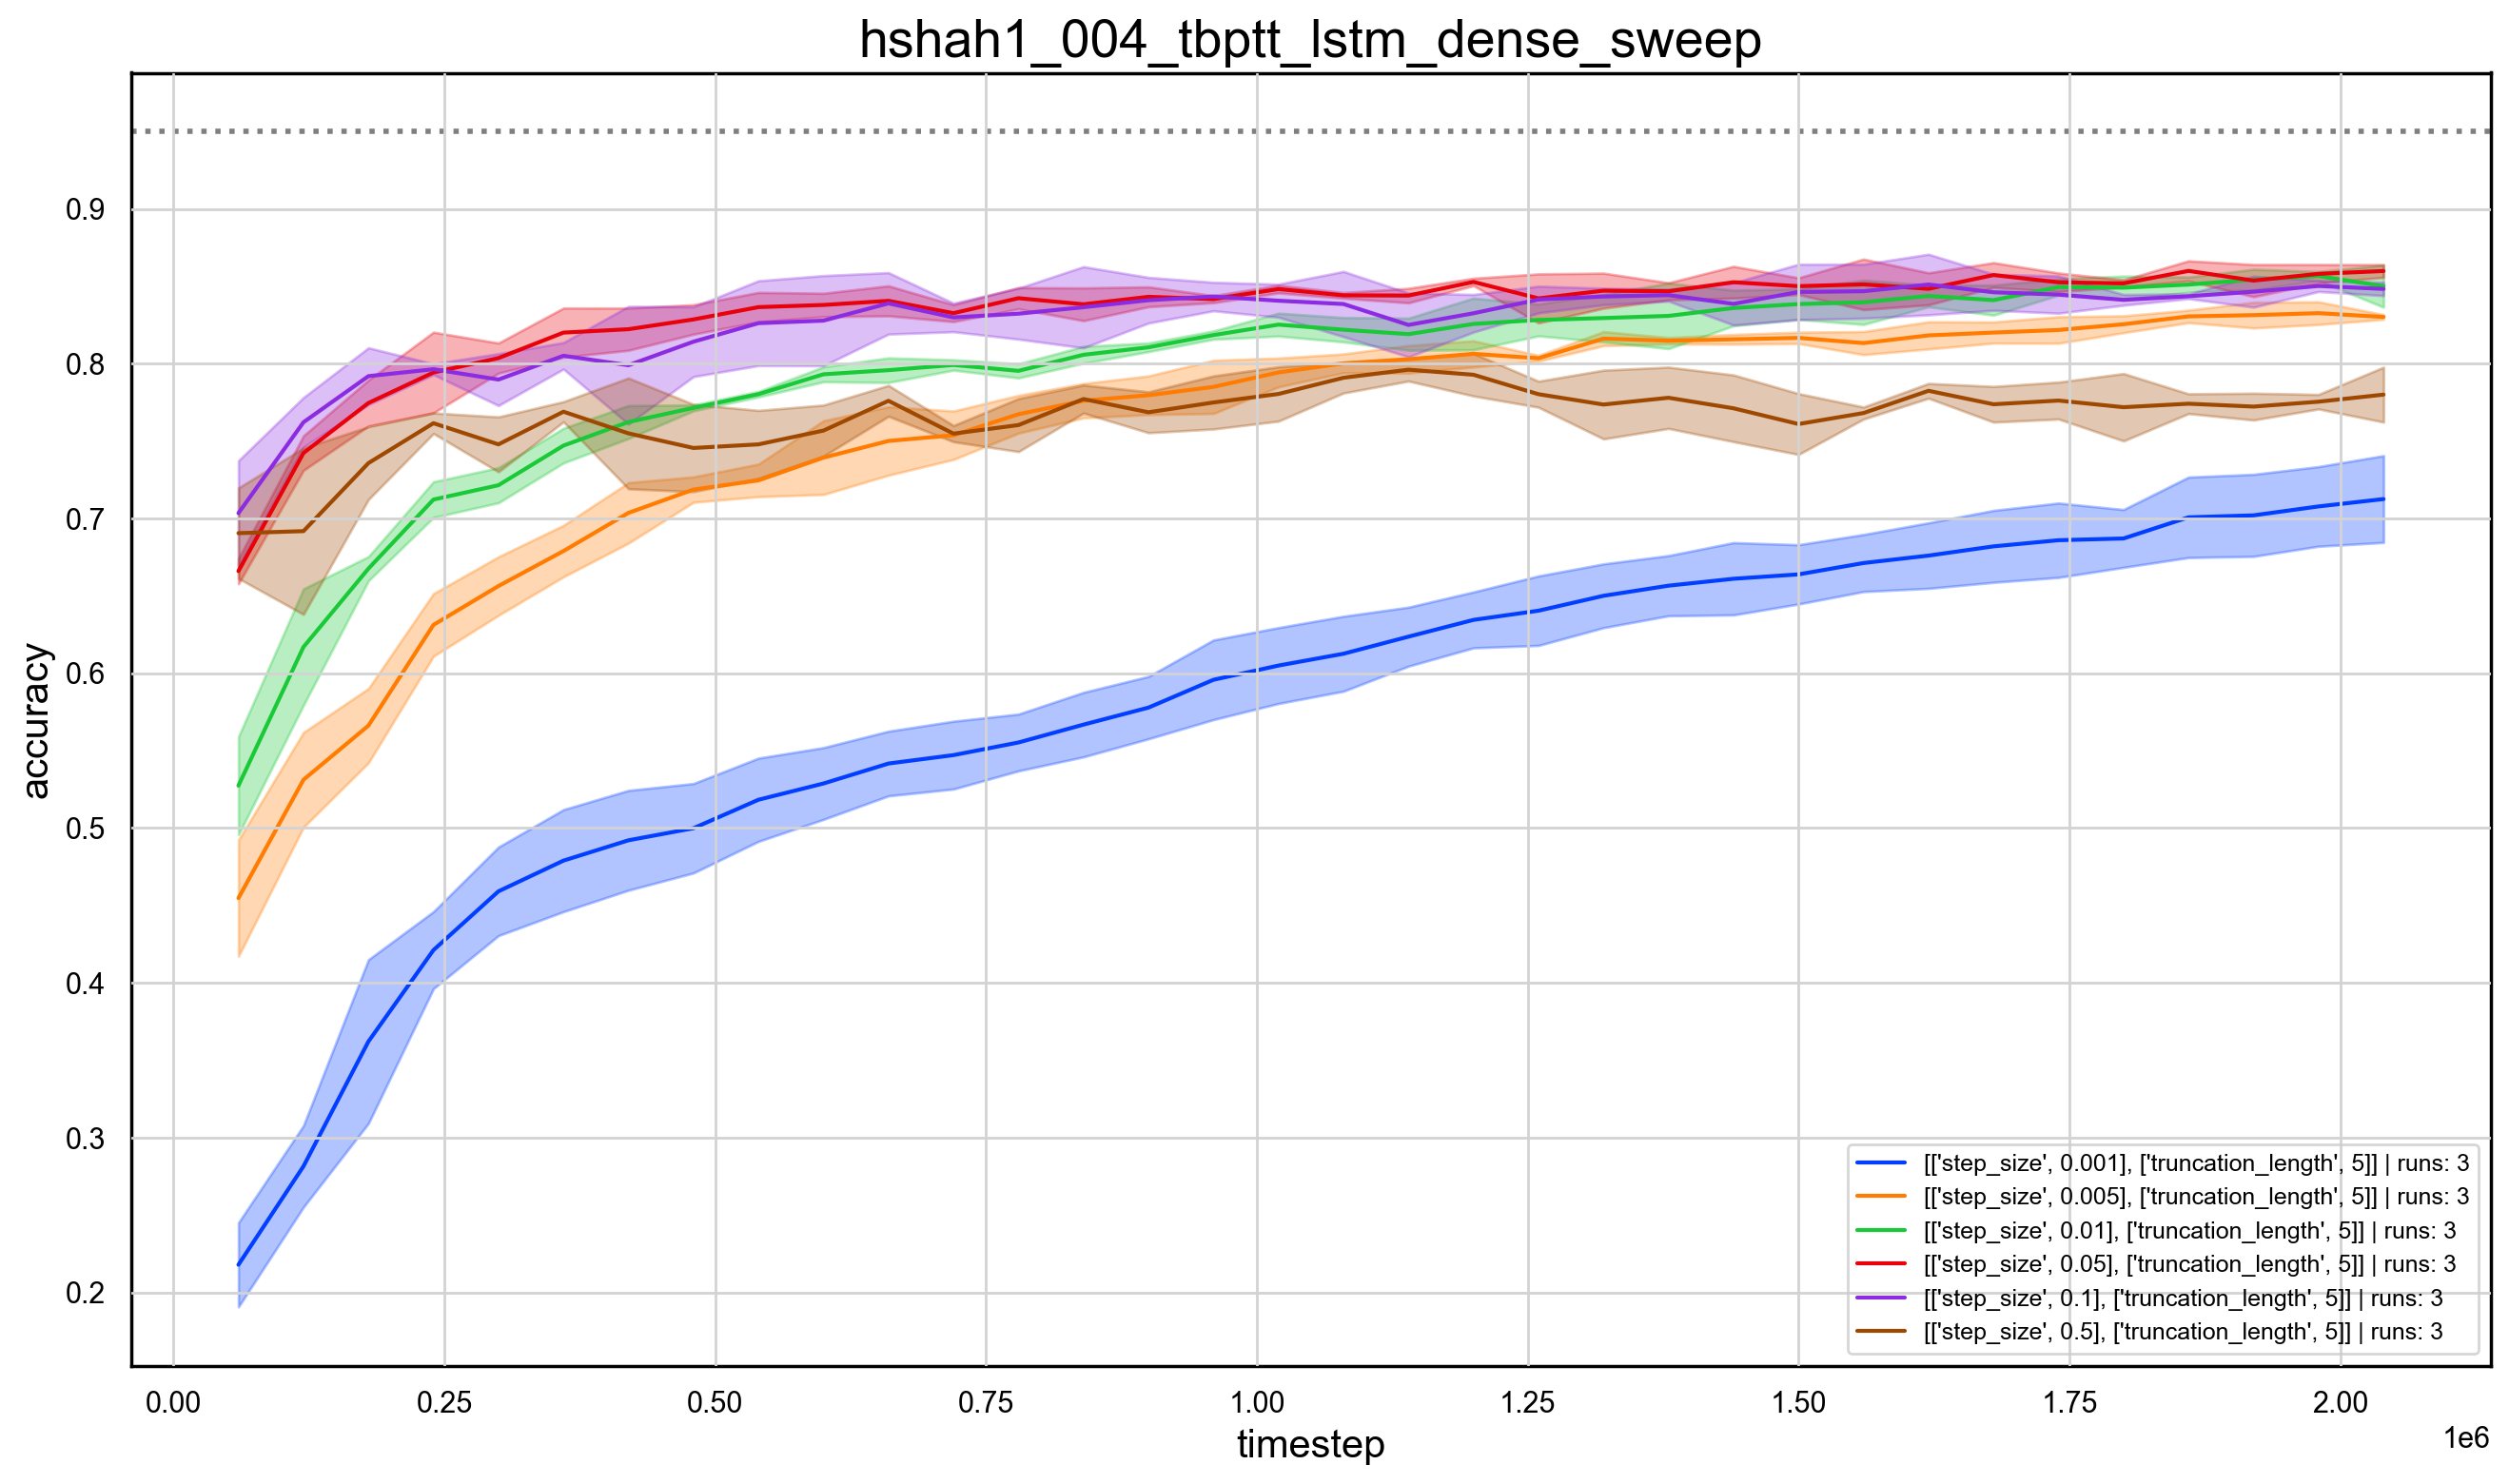

In [136]:
plt_name = f'hshah1_004_tbptt_lstm_dense_sweep'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 34
for params in np.unique(pd.read_sql(f'select step_size from runs', db3.conn).to_numpy().squeeze()):
    conditions = [['step_size', params],
                 ['truncation_length', 5]]

    plt_with_err(comment4, NSTEPS, db4, colors[color_idx], str(conditions), conditions)
    color_idx+=1

plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()

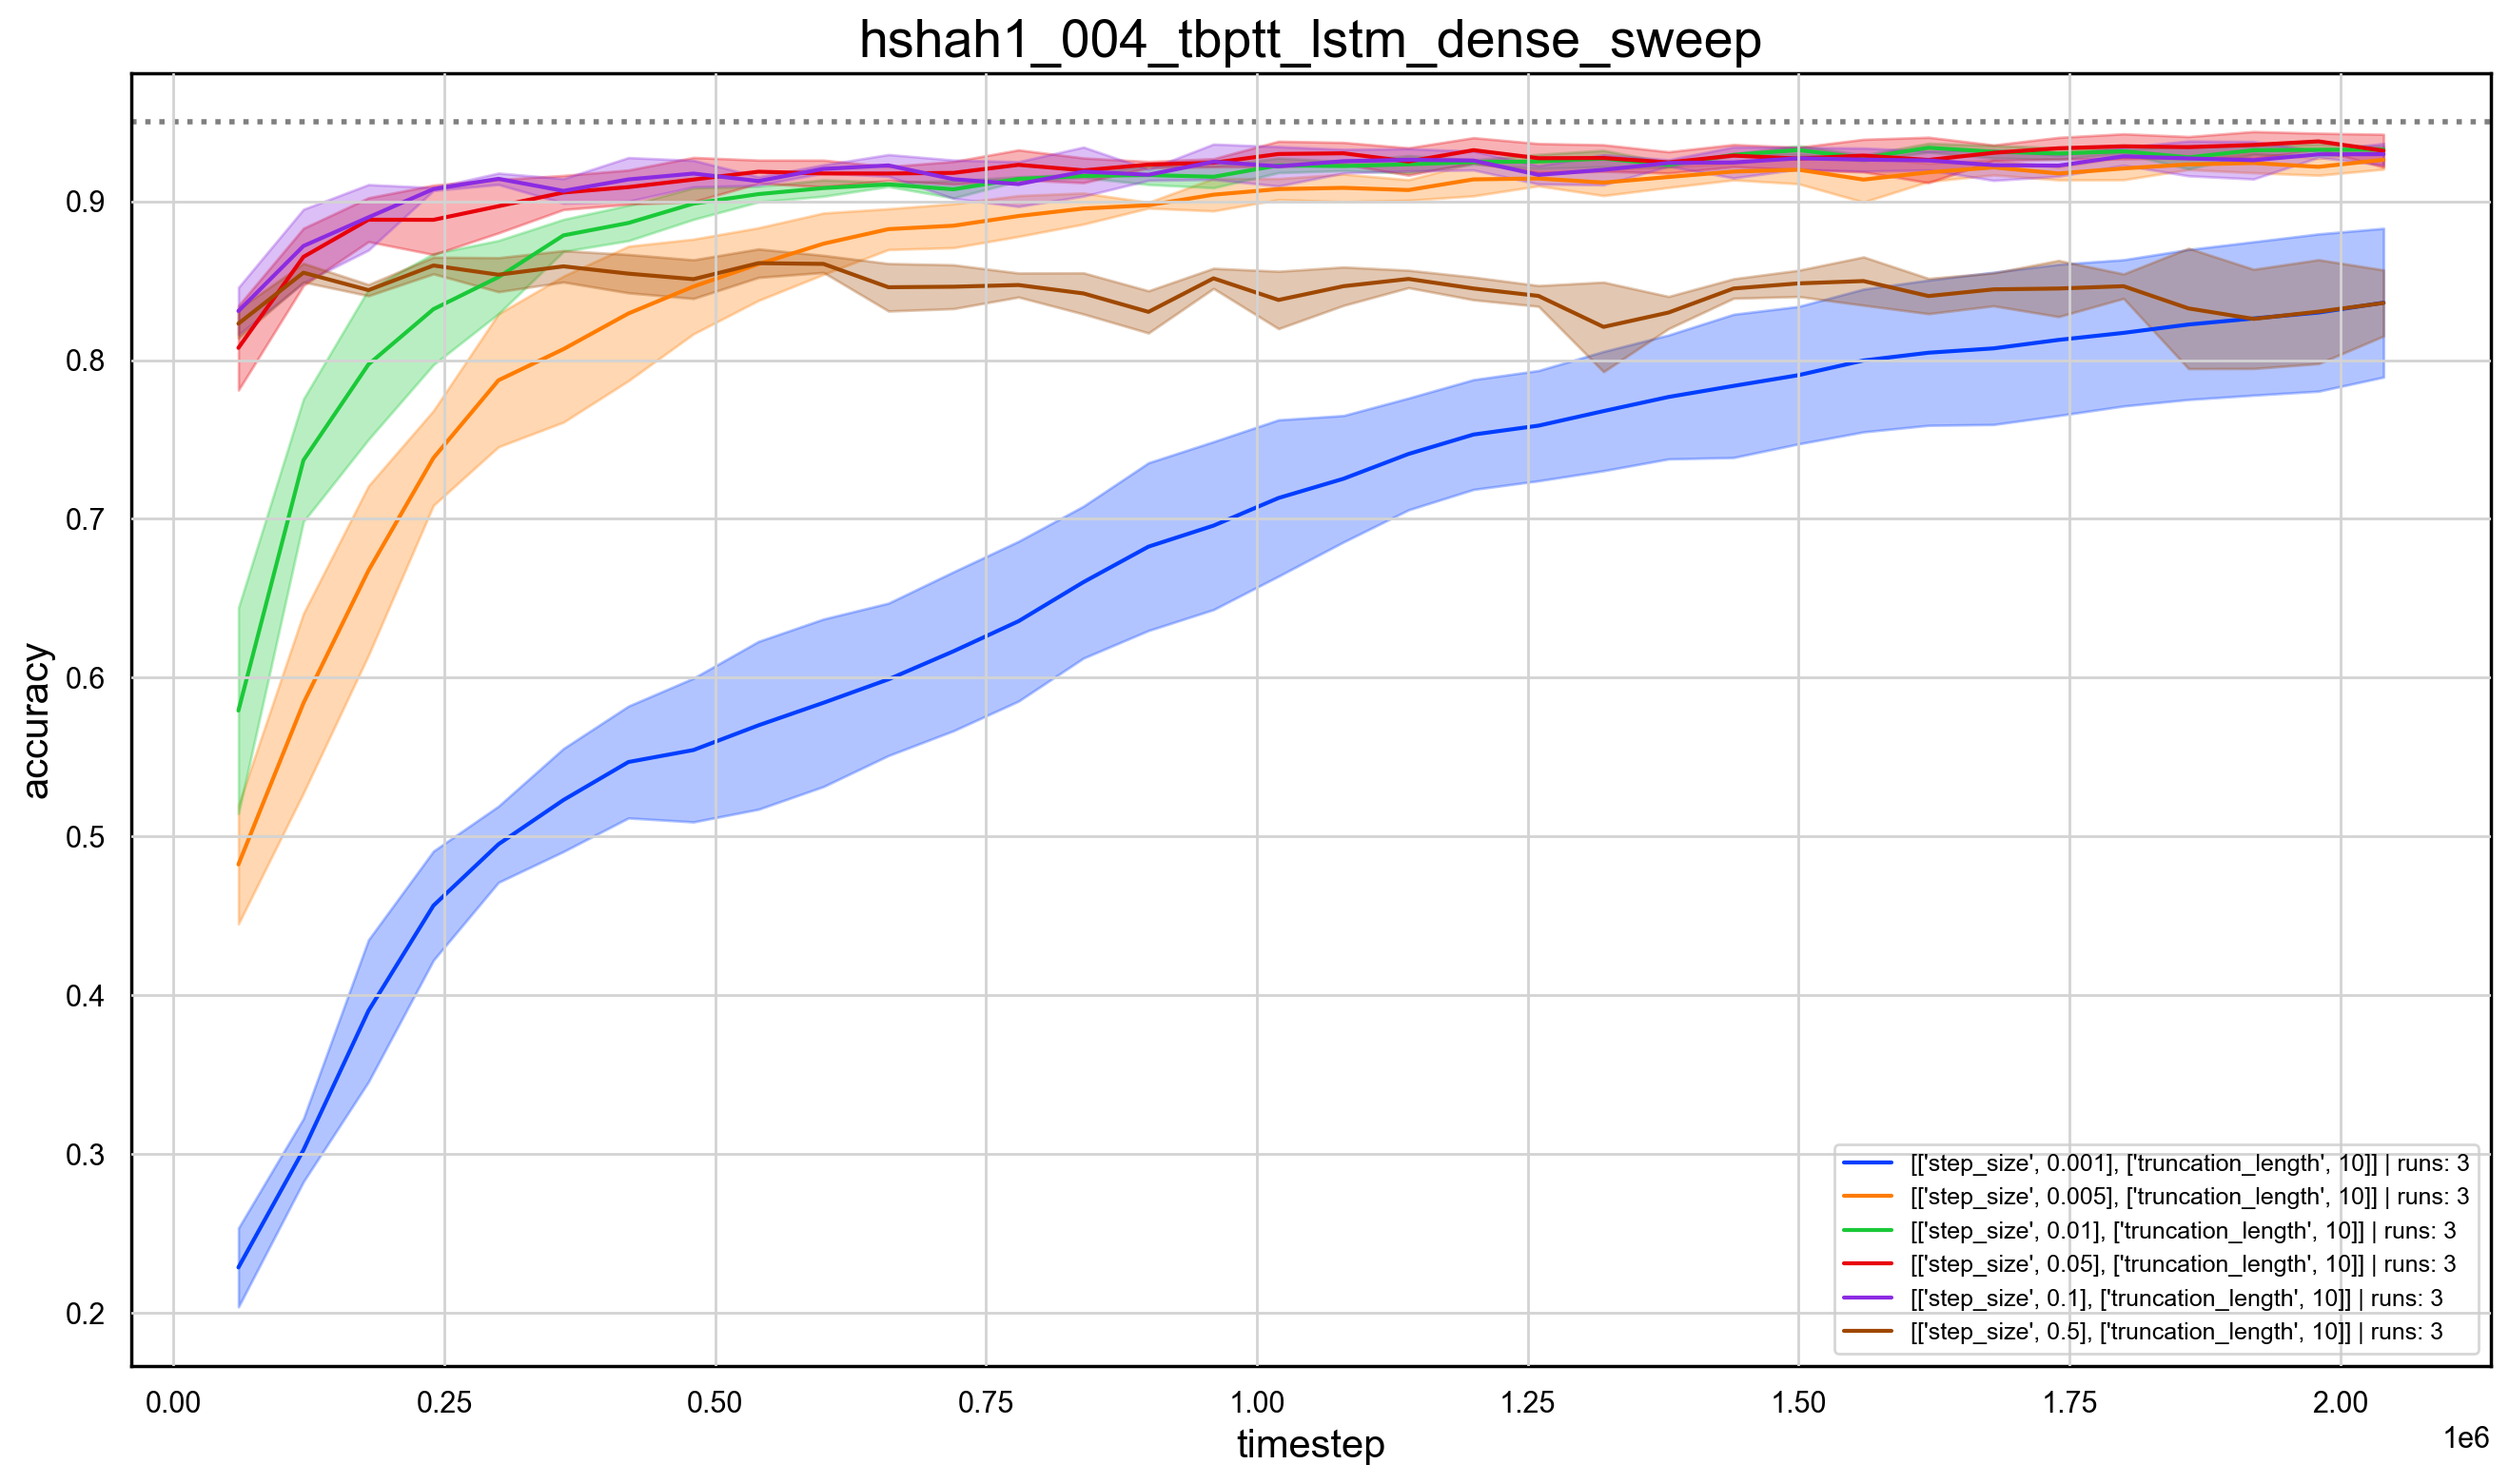

In [137]:
plt_name = f'hshah1_004_tbptt_lstm_dense_sweep'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep')
plt.ylabel('accuracy')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0

NSTEPS = 34
for params in np.unique(pd.read_sql(f'select step_size from runs', db3.conn).to_numpy().squeeze()):
    conditions = [['step_size', params],
                 ['truncation_length', 10]]

    plt_with_err(comment4, NSTEPS, db4, colors[color_idx], str(conditions), conditions)
    color_idx+=1

plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()

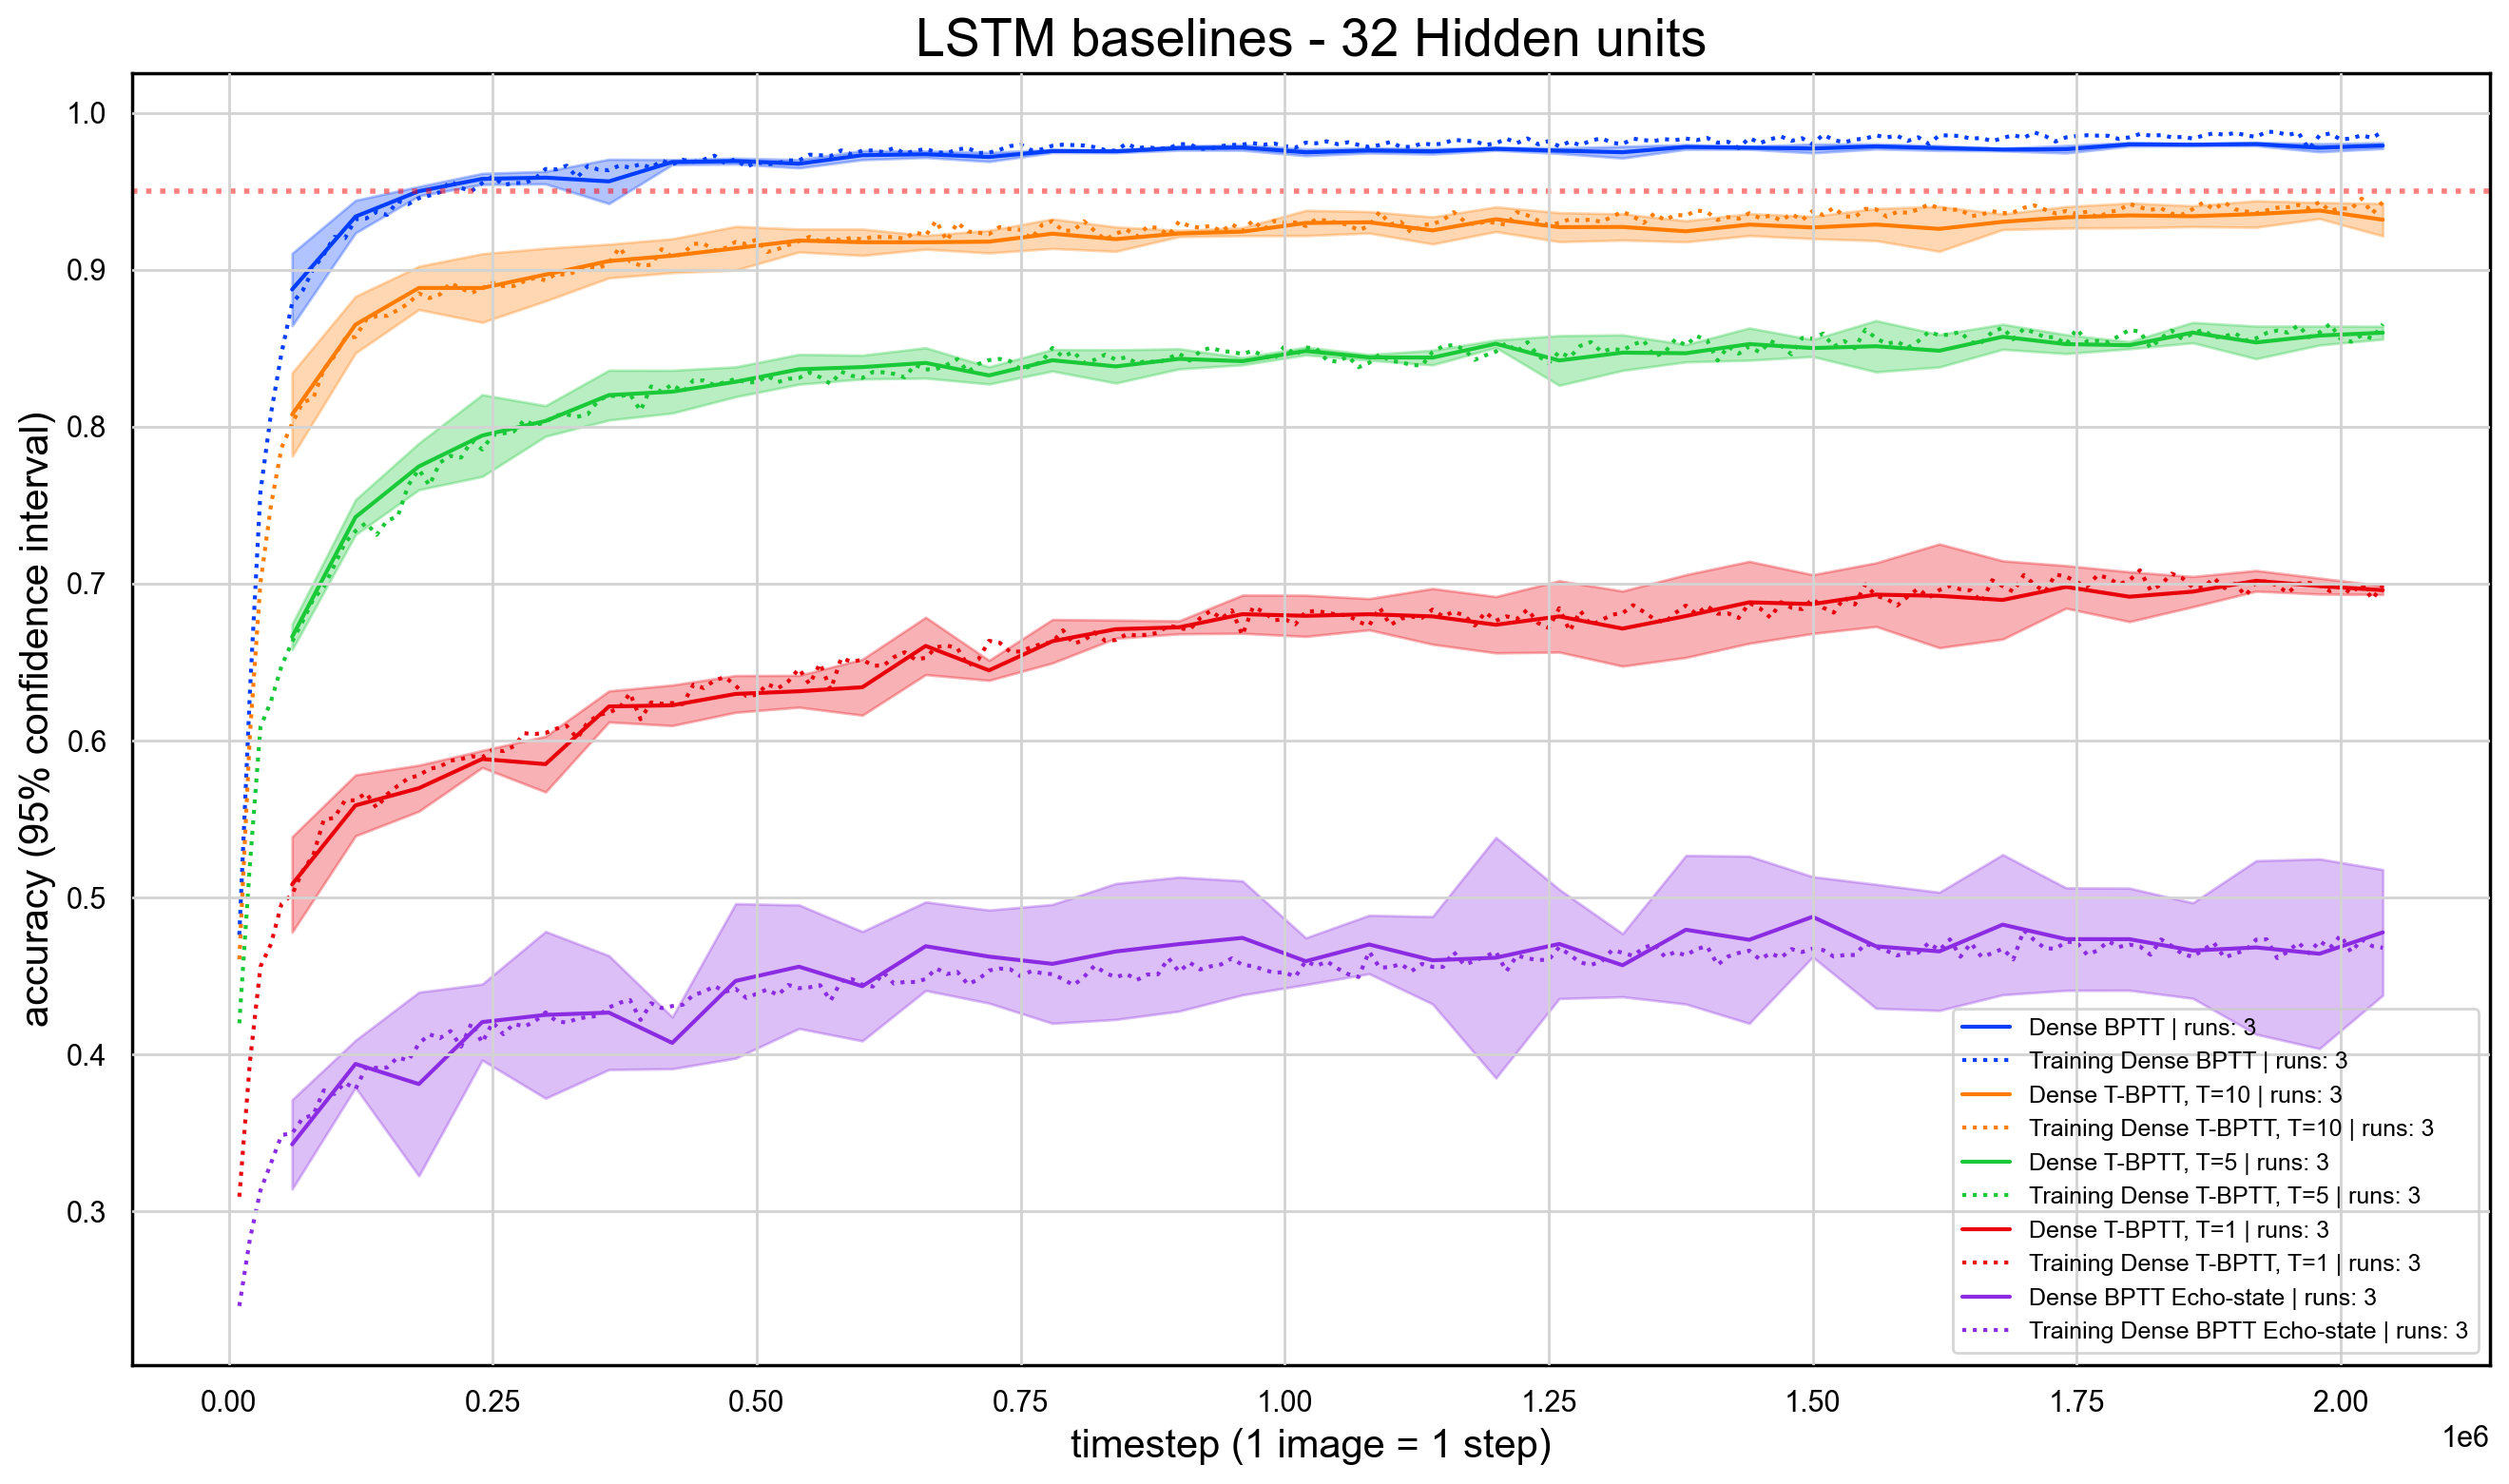

In [150]:
plt_name = f'LSTM baselines - 32 Hidden units'
plt.figure(figsize=(16,9), dpi=200)
plt.title(plt_name)
plt.xlabel('timestep (1 image = 1 step)')
plt.ylabel('accuracy (95% confidence interval)')

colors = plt.cycler(color=sns.color_palette("bright", n_colors=6)).by_key()['color']
color_idx = 0


conditions = [['step_size', 0.05]]
plt_with_err(comment2, 34, db2, colors[color_idx], "Dense BPTT", conditions)
plt_with_err(comment2, 204, db2, colors[color_idx], "Training Dense BPTT", conditions, "training_metrics")
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 10]]
plt_with_err(comment4, 34, db4, colors[color_idx], "Dense T-BPTT, T=10", conditions)
plt_with_err(comment4, 204, db4, colors[color_idx], "Training Dense T-BPTT, T=10", conditions, "training_metrics")
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 5]]
plt_with_err(comment4, 34, db4, colors[color_idx], "Dense T-BPTT, T=5", conditions)
plt_with_err(comment4, 204, db4, colors[color_idx], "Training Dense T-BPTT, T=5", conditions, "training_metrics")
color_idx+=1

conditions = [['step_size', 0.05], ['truncation_length', 1]]
plt_with_err(comment4, 34, db4, colors[color_idx], "Dense T-BPTT, T=1", conditions)
plt_with_err(comment4, 204, db4, colors[color_idx], "Training Dense T-BPTT, T=1", conditions, "training_metrics")
color_idx+=1

conditions = [['step_size', 0.05]]
plt_with_err(comment3, 34, db3, colors[color_idx], "Dense BPTT Echo-state", conditions)
plt_with_err(comment3, 204, db3, colors[color_idx], "Training Dense BPTT Echo-state", conditions, "training_metrics")
color_idx+=1


plt.axhline(y=0.95, color='red', linestyle=':', linewidth=2, alpha=0.5)
plt.legend(prop={'size': 9})
plt.show()